In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Chargement des données
data = pd.read_csv('data/balanced_data.csv')

C:\Users\asus\AppData\Local\Temp\ipykernel_7784\3957017408.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/balanced_data.csv')


In [4]:
# Vérifier les premières lignes pour comprendre la structure
print(data.head())

# Mise à jour de la colonne 'anomalie' en fonction de la colonne 'type'
data['anomalie'] = data['type'].apply(lambda x: 0 if str(x).strip().lower() == 'pas d\'anomalie' else 1)

# Vérification des résultats
print(data[['type', 'anomalie']].head())

  user_number             datetime  Consommation  cluster anomalie  \
0        0_39  2016-03-01 01:02:47             7      0.0      0.0   
1        0_39  2016-03-01 02:02:47             8      0.0      0.0   
2        0_39  2016-03-01 03:02:45             3      0.0      0.0   
3        0_39  2016-03-01 04:02:45             0      0.0      0.0   
4        0_39  2016-03-01 05:02:45             0      0.0      0.0   

             type  
0  pas d'anomalie  
1  pas d'anomalie  
2  pas d'anomalie  
3  pas d'anomalie  
4  pas d'anomalie  
             type  anomalie
0  pas d'anomalie         0
1  pas d'anomalie         0
2  pas d'anomalie         0
3  pas d'anomalie         0
4  pas d'anomalie         0


Nombre de lignes pour le cluster 1 : 102155


C:\Users\asus\AppData\Local\Temp\ipykernel_7784\4140246237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster_1['anomalie'] = data_cluster_1['anomalie'].astype(int)


Nombre d'échantillons générés : 102153
Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     27014
           1       1.00      0.79      0.89      3632

    accuracy                           0.98     30646
   macro avg       0.99      0.90      0.94     30646
weighted avg       0.98      0.98      0.97     30646

Exactitude : 0.9755922469490309
Précision pour la classe '1' (anomalie) : 0.9996534996534997


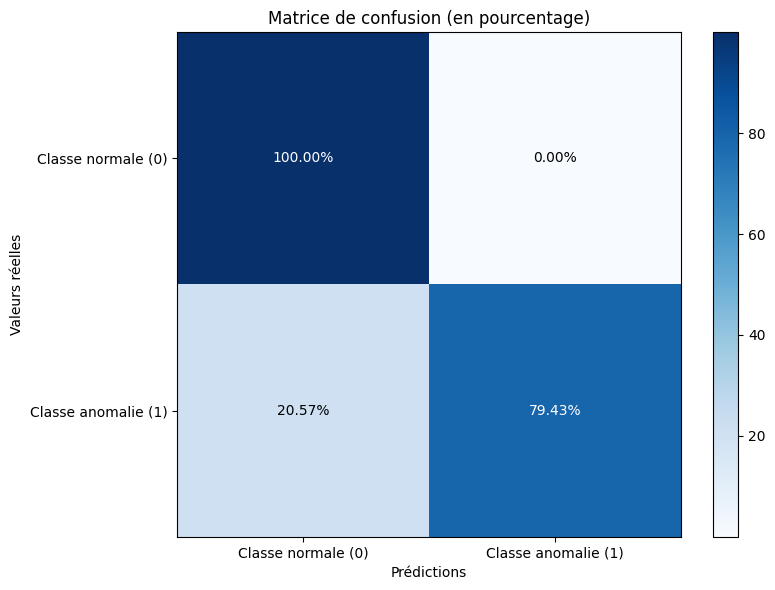

In [6]:


# Filtrer pour le cluster 1 uniquement
data_cluster_1 = data[data['cluster'] == 1]
print(f"Nombre de lignes pour le cluster 1 : {len(data_cluster_1)}")

# Nettoyer la colonne 'anomalie' (convertir en entier)
data_cluster_1['anomalie'] = data_cluster_1['anomalie'].astype(int)

# Créer les fenêtres glissantes
def create_sliding_windows(data, window_size, step_size):
    """
    Génère des fenêtres glissantes à partir des données avec chevauchement.
    """
    X, y = [], []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        # Les caractéristiques sont la consommation
        X.append(window['Consommation'].values)
        # L'étiquette est 1 si une anomalie est présente dans la fenêtre
        y.append(window['anomalie'].max())
    return np.array(X), np.array(y)

# Paramètres des fenêtres glissantes
window_size = 3 # Taille de la fenêtre (nombre de lignes par fenêtre)
step_size = window_size // 2  # Pas (chevauchement de 50 %)

# Générer les données pour le modèle
X, y = create_sliding_windows(data_cluster_1, window_size, step_size)
print(f"Nombre d'échantillons générés : {len(X)}")

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle Random Forest
clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)  # Ajustez les paramètres si nécessaire
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation du modèle
print("Rapport de classification :")
print(classification_report(y_test, y_pred))
print(f"Exactitude : {accuracy_score(y_test, y_pred)}")

# Précision pour la classe 1 (anomalie)
precision_class_1 = (y_pred == 1) & (y_test == 1)
print(f"Précision pour la classe '1' (anomalie) : {precision_class_1.sum() / (y_pred == 1).sum() if (y_pred == 1).sum() > 0 else 0}")

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Normaliser la matrice pour obtenir des pourcentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


# Afficher la matrice avec matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues')

# Ajouter une barre de couleur
cbar = ax.figure.colorbar(im, ax=ax)

# Ajouter les labels
classes = ['Classe normale (0)', 'Classe anomalie (1)']  # Étiquettes des classes
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       ylabel='Valeurs réelles',
       xlabel='Prédictions')

# Ajouter les pourcentages dans les cases
fmt = '.2f'  # Format des nombres
thresh = cm_percentage.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_percentage[i, j], fmt) + '%',
                ha="center", va="center",
                color="white" if cm_percentage[i, j] > thresh else "black")

plt.title("Matrice de confusion (en pourcentage)")
plt.tight_layout()
plt.show()
